# BE 521: Homework 8 Questions

## Deep Learning
### Spring 2024
Developed by William Ojemann

64 points

### Due: March 28th, 2024

Objective: Apply deep learning to a brain-computer interfacing problem

## Overview
The goal of this homework is to add time series prediction and deep learning to your brain-computer interfacing toolkit. In this homework we will be developing a deep learning framework that we can use for seizure detection loosely following the procedure described by Bhattacharya et al., 2023.

If you remember from the reading... The model they describe is first trained in autoregression, and then they use the error of the model to determine whether the current sample is a seizure clip or not.

The first section will guide you through how to build a Long-Short Term Memory (`LSTM`) neural network using a toy signal to help ensure that the model is working. In the second section, we will apply the model we built to detecting seizures from one patient: `HUP235`.

In [ ]:
!jupyter nbconvert --to html YuanchaoZhang_HW8\\.ipynb

In [1]:
# iEEG imports
!pip install git+https://github.com/ieeg-portal/ieegpy.git # Install ieegpy toolbox directly from github
from ieeg.auth import Session

# Imports for deep learning
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Scientific computing imports
import numpy as np
import scipy as sc
import pandas as pd
from scipy.linalg import hankel
from tqdm import tqdm
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

  Cloning https://github.com/ieeg-portal/ieegpy.git to /tmp/pip-req-build-1y3uzgu7
  Running command git clone --filter=blob:none --quiet https://github.com/ieeg-portal/ieegpy.git /tmp/pip-req-build-1y3uzgu7
  Resolved https://github.com/ieeg-portal/ieegpy.git to commit 080bfa42a8503380ef164b5e7b116613f75073bb
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.0/98.0 kB 1.9 MB/s eta 0:00:00
  Created wheel for ieeg: filename=ieeg-1.6-py3-none-any.whl size=27499 sha256=0e26edab868cee58f97a205b9deb2c60edf07bd8e438f23c26ca28f1c72f7901
  Stored in directory: /tmp/pip-ephem-wheel-cache-3foct_m8/wheels/c0/2a/4d/452574b1c3c63e86df54de09161463c0509e9eeffc1aad898e
Successfully built ieeg


In [2]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  random.seed(seed)
set_seed(5210)

## 0. Introduction (2pts)
Before we get started with coding, describe how the model in Bhattacharya et al. works. What difference between interictal (time between seizures that is considered to be "normal" EEG) and ictal (Seizure activity that occurs in patients with epilepsy) data are they leveraging to build a seizure detector? (2 pts)

**My Answer Here:**

Bhattacharya et al.'s suggested seizure detection model **uses machine learning approaches with deep neural networks** to discriminate between data about seizure activity (ictal) and interictal (regular EEG activity between episodes).

Specifically, this article's research aims to use a basic **Long Short Term Memory (LSTM) Network and a clustering technique** to complete the task of unsupervised seizure categorization.

To train a machine learning model(LSTM Network with clustering) to distinguish between interictal and ictal patterns: **pertinent characteristics from EEG signals must be extracted and represented, and the model's performance must be assessed(Accuracy, Precision, Recall, etc.).** The program can identify seizures from EEG readings by learning the unique patterns linked to each kind of activity.

## 1. LSTMs, autoregression, and deep learning

Because this homework is more about deep learning, we'll provide some of the basic data for you. The following cell will create a sinusoidal signal with frequency $\frac{fs}{2\pi}$, for the duration of data_len (in seconds), and n_channels number of channels.

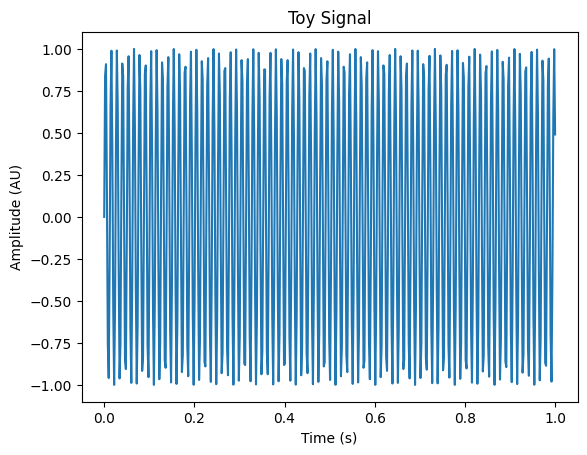

In [3]:
fs = 500
data_len = 1 # seconds
n_channels = 1
data = np.sin(torch.arange(0,data_len*fs,dtype=torch.float64).expand(n_channels,data_len*fs).T)
# data = torch.arange(0,data_len*fs,dtype=torch.float64).expand(n_channels,data_len*fs).T
sns.lineplot(x=np.linspace(0,1,fs),y=data.squeeze())
plt.ylabel('Amplitude (AU)');
plt.xlabel('Time (s)');
plt.title('Toy Signal');

In [4]:
# print(data.shape)
# print(data)

If you remember from Bhattacharya et al., in order to detect seizures they split 1 second clips into 13 sample sequences and then used the first 12 samples as an input to predict the 13th. This can be generalized to: input samples $X = [x_i,x_{i+1},..., x_{i+11}]$ to predict y = $x_{i+12}$. This type of prediction, taking in samples from a previous time point to predict the next time point is called autoregression.

To facilitate an autoregression problem, we need to turn our 1 channel x 500 samples signal into a matrix where each row is a seperate input/prediction pair, or "sequence". More specifically, we will be transforming the one-second clip into a matrix of i sequences by j = 13 (12 input + 1 output) samples using something called a hankel matrix `scipy.linalg.hankel`.

To build a Hankel matrix, you can also think of each sequence as a window, so each row in the matrix should be a unique window, or sequence, that we're going to use to train our auto regression model to take in the 12 previous time points and predict the 13th. Because we have 500 samples in total, and require 13 continuous points to build a window, we can only have 500 - 13 + 1 = 488 windows/sequences.

In the example shown below, they have 4 input samples, 1 output sample, and 1 channel on a signal with 9 samples in it. So the dimensions of the Hankel matrix are *9 - (4+1) + 1 = 5 sequences* x *(4 + 1) samples in a sequence* x *1 channel*.

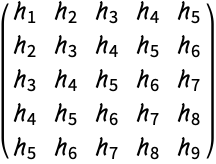

### 1 (4 pts)

#### 1a
Create a tensor called `data_mat` with the following dimensions: i = 488 sequences, j = 13 (input + output) samples, and k = 1 channels. Print out the dimensions of your hankel matrix (2 pts).


Now, becuase we're going to be using the deep learning package PyTorch, we want our `data_mat` to be a `torch.tensor` rather than an `np.array`. Cast the `data_mat` to a `torch.tensor` (1 pt)

Hint: assuming there's just one channel and it is one second of data sampled at 500Hz, given m and n the first row should be $[x_1, x_2, x_3,..., x_{13}]$ and the last row should be $[x_{488},x_{489},x_{490},...,x_{500}]$. The first column should then be all of the values from $x_{1}$ to $x_{488}$

*Hint: you can also think of this as 13 sample, left aligned windows with a stride of 1 sample*

In [5]:
# My Code Here
# Number of sequences
### Train our auto regression model to take in the 12 previous time points and predict the 13th
### Because we have 488 samples in total, and require 13 continuous points to build a window
### We can only have (i = 500 - 13 + 1 = 488) windows/sequences.
num_sequences = 488

# Number of input samples
### j = 13 (input + output) samples
# num_InOut_samples = 13

# Number of output samples
### k = 1 channel
# num_channel = 1

### Number of total samples
total_samples = 500

# Construct the Hankel matrix
# data_mat = hankel(np.arange(num_sequences), np.arange(num_InOut_samples))
data_mat = hankel(data[0:num_sequences], data[num_sequences - 1 : total_samples])
# print(data_mat)

### Number of Sequences = i = 488, Number of (Input + Output) = j samples, Number of Channel = k =1
# Print out the dimensions of the Hankel Matrix
print("Dimensions of My Hankel Matrix:", data_mat.shape)

# Convert data_mat to torch.tensor
data_mat = torch.tensor(data_mat)
print("\n\n Convert data_mat to torch.tensor: \n", data_mat)

Dimensions of My Hankel Matrix: (488, 13)


 Convert data_mat to torch.tensor: 
 tensor([[ 0.0000,  0.8415,  0.9093,  ..., -0.5440, -1.0000, -0.5366],
        [ 0.8415,  0.9093,  0.1411,  ..., -1.0000, -0.5366,  0.4202],
        [ 0.9093,  0.1411, -0.7568,  ..., -0.5366,  0.4202,  0.9906],
        ...,
        [ 0.9301,  0.8116, -0.0531,  ..., -0.9802, -0.3631,  0.5878],
        [ 0.8116, -0.0531, -0.8690,  ..., -0.3631,  0.5878,  0.9983],
        [-0.0531, -0.8690, -0.8859,  ...,  0.5878,  0.9983,  0.4910]],
       dtype=torch.float64)


**My Answer Here:**

The Dimensions of My Hankel Matrix: **(488, 13)**

#### 1b
Now we want to split up our `data_mat` into the inputs = 12  and pred_output = 1 contained in each sequence. Create two `torch.tensor`s: `input_data` with num sequences x sequence inputs x 1 channel, and `target_data` with the num sequences x sequence output (1 pts).

*Hint: For pytorch, it's important to keep the dimensionality of our inputs so that they have this format - num sequences x sequence length x input channels*

In [6]:
# My Code Here
# Prepare input and target data for the model here...
# Please cast your torch.tensors to type float to avoid downstream issues:
# my_tensor = my_tensor.float()

num_input_samples = 12
data_mat = data_mat.float()

# Extract input sequences (excluding the output)
input_data = data_mat[:, :num_input_samples].unsqueeze(-1)
# input_data = target_data.float()
# print(len(input_data))
# print(input_data)

# Extract output sequences
target_data = data_mat[:, num_input_samples:]
# target_data = target_data.float()
# target_data = target_data.squeeze(1)
# print(len(target_data))

# Print the dimensions of input_data and target_data
print("Dimensions of input_data:", input_data.shape)
print("Dimensions of target_data:", target_data.shape)

Dimensions of input_data: torch.Size([488, 12, 1])
Dimensions of target_data: torch.Size([488, 1])


### 2 (8 pts)
In this section we will be setting up our LSTM. We talked about different neural network architecutres in the last recitation, but we'll briefly recap what an LSTM is here. An LSTM, or Long Short-Term Memory model, is a type of recurrent neural network designed to process sequential data - like language or, in our case, EEG recordings. An LSTM traverses across a sequence, at each point updating the values in its hidden state based on the previous hidden state and the current element of the sequence. For a more in-depth explanation of how LSTMs "forget" irrelevant information or store hidden states, I recommend interacting with ChatGPT to guide your learning.

For this homework, we're going to just be applying [PyTorch's implementation of LSTMs](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) rather than diving into the theory.

#### 2a
Like we talked about in the recitation, we can use a pytorch dataloader to help facilitate training and generating predictions using a pytorch model. Put your `input_data` and `target_data` into a TensorDataset, and then create a DataLoader from that dataset that outputs batches of 100 samples. Be sure to leave all other settings as defaults (1 pt).

We've already imported the classes `TensorDataset` and `DataLoader` for you to use in this notebook

In [7]:
# Create DataLoader for training
tensor_dataset = TensorDataset(input_data, target_data)
# print(tensor_dataset)
data_loader = DataLoader(tensor_dataset, batch_size = 100, shuffle=False)
# print(data_loader)

#### 2b
Here, you're going to define the architecture of the LSTM model from the paper. We talked about coding neural networks in pytorch in recitation, but for this question we're going to leave it up to you. We highly recommend you use [ChatGPT](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjdkojbhP6EAxX5ElkFHfM7CJwQFnoECAsQAQ&url=https%3A%2F%2Fchat.openai.com%2F&usg=AOvVaw139HWUX4D802zbDuJCdFg9&opi=89978449) and ask it something along the lines of "what are the components of a basic LSTM model in pytorch with..."

Create an LSTM architecture called `LSTMModel` that takes in 3 inputs when you initialize it: input_size, hidden_size, and output_size (4 pts).

*Hint: Some quick definitions - the input size is the number of channels that the data has, in our case this is one. The hidden size is the size of the hidden state variable, and the output size is the number of channels that our data has, in our case this is one again. When defining the LSTM, you don't have to include the sequence length, since the model will just traverse across the whole sequence regardless of length.*

*Hint: While you're building this architecture, be sure to go line by line and ask chatGPT to explain any parts of the model code that are confusing. It can be a super useful debugging tool. You can also use https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html as a helpful resource*

In [8]:
# My Code Here
# Define LSTM model
class LSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(LSTMModel, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size

    # Define the LSTM layer
    self.lstm = nn.LSTM(input_size, hidden_size, batch_first = True)

    # Define the output layer
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, input_seq):
    # Initialize hidden state with zeros
    h0 = torch.zeros(input_seq.size(0), self.hidden_size)

    # Initialize cell state with zeros
    c0 = torch.zeros(input_seq.size(0), self.hidden_size)

    # Forward propagate LSTM
    # lstm_out, _ = self.lstm(input_seq, (h0, c0))
    lstm_out, _ = self.lstm(input_seq, (h0.unsqueeze(0), c0.unsqueeze(0)))


    # Only take the output from the final time step
    output = self.fc(lstm_out[:, -1, :])

    return output

Initialize the model with the same input, hidden, and output size as the paper and print the model: `print(model)`. (2 pts)

It should look like this:

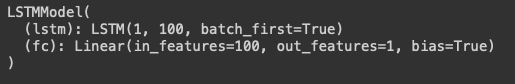

In [9]:
# My Code Here
input_size = 1
hidden_size = 100
output_size = 1

# Create an instance of the LSTMModel
model = LSTMModel(input_size, hidden_size, output_size)
print(model)

LSTMModel(
  (lstm): LSTM(1, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)


#### 2c

Before we train the model, we need to define the `criterion` (the metric that we will use to evaluate the model's predictions, often called the loss function) and the `optimizer` (the algorithm that updates the weights of the model as it trains).

We use MSE - mean squared error - to evaluate the loss of auto regression because it allows us to effectivily compare the distance from the true value, $y_i$, and the value we predict, $\hat{y}_i$, using the following equation:

$MSE = \frac{1}{N}\sum{(y_i-\hat{y}_i)^2}$

Models that perform really poorly will predict values for $\hat{y}_i$ that are different from/unrelated to the value of $y_i$ and will have a higher MSE as a result.

In accordance with the paper, create instances of an Adam `optimizer` object with a learning rate of 0.001, and an MSELoss `criterion` object (1 pts). This is another problem where ChatGPT can help navigate the material and code.

In [10]:
# Define loss function and optimizer

# Define the learning rate for the optimizer
optimizer_learning_rate = 0.001

# Define loss function
optimizer = optim.Adam(model.parameters(), lr = optimizer_learning_rate)

# Define optimizer
criterion = nn.MSELoss()

# Print the optimizer and criterion
print("Optimizer:", optimizer)
print("Criterion:", criterion)

Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Criterion: MSELoss()


### 3 (6 pts)

Let's put it all together!

Create a training loop that trains your model for 100 epochs (iterations through the whole training dataset) using your dataloader (to load batches of data), model (to generate predictions), criterion or loss function (to evaluate the predictions against the targets), and optimizer (to update the model weights).

In layman's terms, your training loop is going to:

1.    loop through each epoch, and within each epoch, loop through each batch in your dataloader
2.   generate predictions for the 13th sample based on the previous 12 samples in each segment in your batch
3.   calculate the loss comparing the true and predicted 13th samples across the whole batch
4.   update your model's weights using the optimizer

ChatGPT will once again be your friend here for what to include in the loop as well as understanding what each step does.


The training loop should print out the loss*1000 in the last batch every 10 epochs (4 pts).

*Hint: Your final loss at epoch 100 should be 0.0074. If it's close but not exact, try pressing "restart and run all" under the runtime tab. Make sure that you are not iterating through the dataloader in any cells before you train the model, this can mess up the random seed!*

In [11]:
# Training loop
# print(data_loader)
num_epochs = 100

for epoch in range(num_epochs):

  # My Code Here!
  # Iterate over the dataset

  for _, (inputs, targets) in enumerate(data_loader):
  # for inputs, targets in data_loader:

    # print(inputs)
    # print(targets)

    ### Zero Gradients
    optimizer.zero_grad()

    ### Foward Pass
    pred_output = model(inputs)

    ### Compute Loss Function
    loss = criterion(pred_output, targets)

    ### Backward Pass
    loss.backward()

    ### Gradient Descent
    optimizer.step()

  if epoch % 10 == 9:
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()*10000:.4f}')

Epoch [10/100], Loss: 144.3850
Epoch [20/100], Loss: 0.6563
Epoch [30/100], Loss: 0.0158
Epoch [40/100], Loss: 0.0103
Epoch [50/100], Loss: 0.0098
Epoch [60/100], Loss: 0.0093
Epoch [70/100], Loss: 0.0089
Epoch [80/100], Loss: 0.0084
Epoch [90/100], Loss: 0.0079
Epoch [100/100], Loss: 0.0074


**My Answer Here:**

Epoch [10/100], Loss: 144.3850

Epoch [20/100], Loss: 0.6563

Epoch [30/100], Loss: 0.0158

Epoch [40/100], Loss: 0.0103

Epoch [50/100], Loss: 0.0098

Epoch [60/100], Loss: 0.0093

Epoch [70/100], Loss: 0.0089

Epoch [80/100], Loss: 0.0084

Epoch [90/100], Loss: 0.0079

**Epoch [100/100], Loss: 0.0074**

### 4 (8 pts)

#### 4a
Now that we have a trained model, we need to find a way to generate the data needed to make predictions. Because our model will ultimately use the squared error loss of autoregression to make predictions about whether a clip is ictal or not, we need a prediction function that can take in our model and a new one-second clip and return the corresponding np.array of MSE values.

The function should take in the trained model and the new 1 second clip, and return an array of mse values for each sequence (12 sample input, 1 sample output) in the clip.
(4pts)

*Hint: When we're training the model, we can take the mean squared error across the entire batch using the criterion function. However, in this case we don't want the mean square error, we want the square error for each prediction: instead of $MSE = \frac{1}{N}\sum{(y_i-\hat{y}_i)^2}$, we want $SE = (y_i-\hat{y}_i)^2$. This can be achieved by setting the batch size of your dataloader to one and using the same criterion function, or you can also write your own square error function and concatenate all of the squared error values across each batch.*

In [12]:
# My Code Here
def predict_mse_values(model, clip):

  mse_values = []

  tmp_input_data = clip[:, :num_input_samples].unsqueeze(-1)
  tmp_target_data = clip[:, num_input_samples:]
  pred_clip_output = model(tmp_input_data)
  squared_error = (tmp_target_data - pred_clip_output) ** 2

  mse_values.append(squared_error.detach().numpy())

  return mse_values

#### 4b
Let's build a function that we can use to visualize the autoregressive predictions the model is making. This won't be used to make ictal/interictal classifications, but is useful for understanding what the model is actually doing.

This function should take in the model and the clip and return an array of predictions for each segment in the clip. This should look very similar to your previous function. (2 pts)

In [13]:
# My Code Here
def generate_autoregressive_predictions(model, clip):

  tmp_input_data = clip[:, :num_input_samples].unsqueeze(-1)
  tmp_target_data = clip[:, num_input_samples:]
  pred_clip_output = model(tmp_input_data)

  return pred_clip_output

#### 4c
Use your function to generate mse values for the data you used to train the model. Create a scatter plot of the mse distribution with segment # on the x axis and loss on the y axis. The plot should have a log-scale y axis. (1 pts)

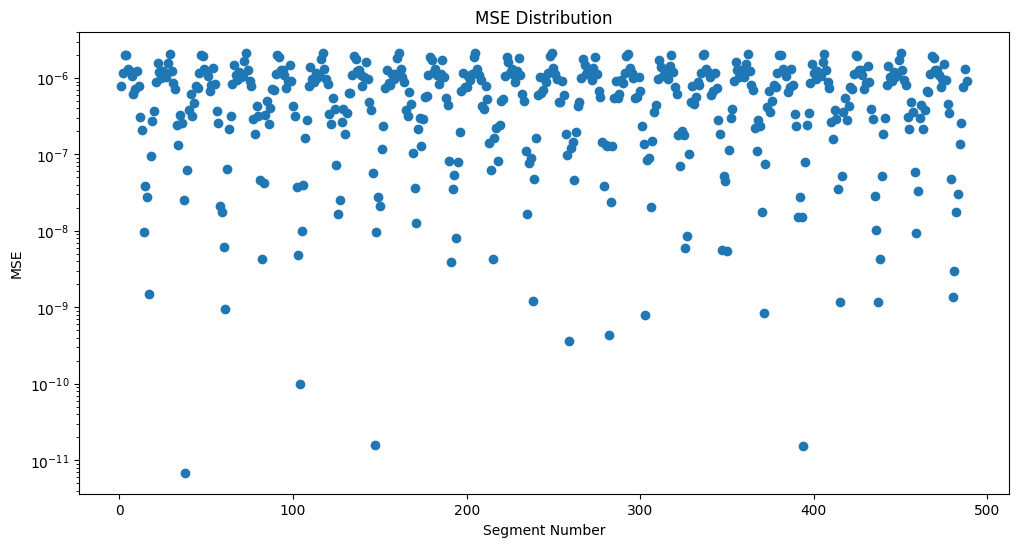

In [14]:
### My Code Here
mse_values = predict_mse_values(model, data_mat)
# print(len(mse_values))

# Get segment numbers (assuming you have 488 segments)
segment_numbers = np.arange(1, 489)
# print(len(segment_numbers))

plt.figure(figsize=(12, 6))
plt.title('MSE Distribution')

# Create a scatter plot
plt.scatter(segment_numbers, mse_values)

plt.xlabel('Segment Number')
# Set y-axis scale to logarithmic
plt.ylabel('MSE')
plt.yscale('log')

# Show plot
plt.show()

#### 4d
Use your predict values function to generate predictions for each sample from $x_{13}$ to $x_{500}$. plot the data values that you're generating predictions for as a blue lineplot, and then overlay a scatterplot of the predictions you're generating in red. Set the transparency of your red scatter plot to 0.3 using the "alpha" argument in plt.scatter() (1 pts).

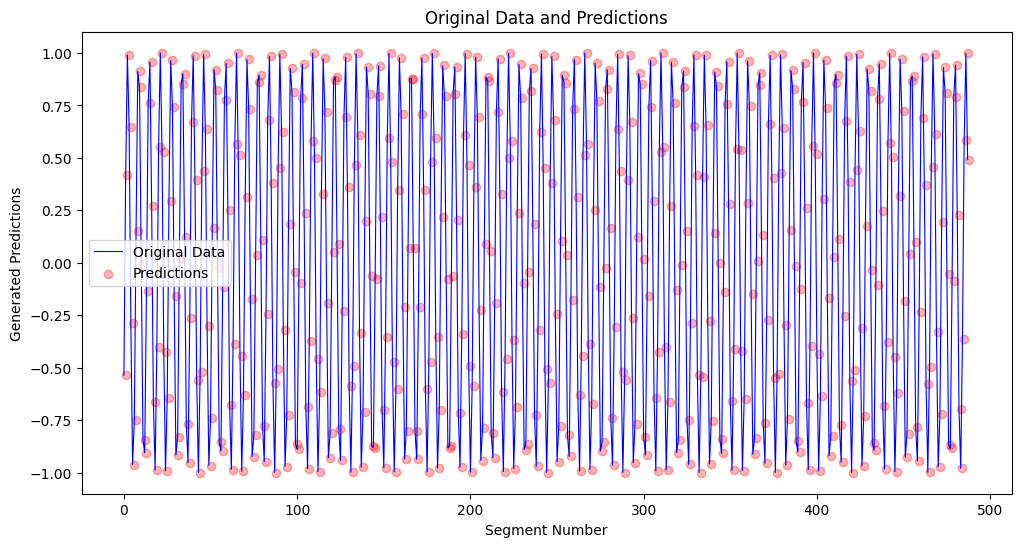

In [15]:
# My Code Here
# print(data_mat[12:])
# print(input_data)
# print(data_mat[:, :num_input_samples])
pred_values = generate_autoregressive_predictions(model, data_mat)
plt.figure(figsize=(12, 6))
plt.title('Original Data and Predictions')
# Plot the original data values as a blue line plot
plt.plot(data[12:500], linewidth = 0.8, color='blue', label='Original Data')

# Overlay a scatter plot of the predictions in red with transparency set to 0.3
plt.scatter(segment_numbers, pred_values.detach().numpy(), color='red', alpha=0.3, label='Predictions')

# Add labels and legend
plt.xlabel('Segment Number')
plt.ylabel('Generated Predictions')
plt.legend()

# Show plot
plt.show()

## 2. Seizure detection

In [16]:
# Resetting the seed for the next section!
set_seed(5210)

### 1 (5 pts)

`HUP235` is a patient with epilepsy who was implanted with intracranial EEG devices to help identify where in the brain their seizures were coming from. Your goal as a BCI/Deep Learning practitioner is to develop a seizure detection algorithm for their seizure onset channel - `LC01` - so that they can alert their caregiver when they've had a seizure.

In [17]:
# My Code Here
with open('/content/Yua_ieeglogin.bin', 'r') as f:
  session = Session('Yuanchz1118', f.read())

# get the specified dataset from IEEG
dataset1 = session.open_dataset('HUP235_phaseII')

dataset1_label = dataset1.get_channel_labels()
print(dataset1_label, "\n")
dataset1_index = dataset1.get_channel_indices(dataset1_label)
print(dataset1_index, "\n")

LC01_Channel_Index = dataset1_label.index('LC01')
print("Index of seizure onset channel - LC01:", LC01_Channel_Index, '\n')

### Seizure Data: Index[30]
timeseries = dataset1.get_time_series_details(dataset1_label[LC01_Channel_Index])
print(timeseries, "\n")
sample_rate = int(timeseries.sample_rate)
print("Smpling Rate of the Seizure:", sample_rate, "Hz", "\n")

start_time = timeseries.start_time
end_time = timeseries.end_time

duration = timeseries.duration
print("Duration of the Seizure:", duration, "us \n")

# test_channel_index = dataset1_label.index('C3')
# print(test_channel_index)

### Extract Seizure Data from an extracellular recording from the third nerve (channel nerve)
# seizure_data = dataset1.get_data(start_time,end_time - start_time + 1,[LC01_Channel_Index])
# seizure_data = load_full_channels(dataset1, duration / 10**6, sample_rate, [LC01_Channel_Index])
# print("The total number of the seizure units:", len(seizure_data), "\n")
# print("Data(mV):\n", seizure_data)

['C3', 'C4', 'Cz', 'EKG1', 'EKG2', 'Fz', 'LA01', 'LA02', 'LA03', 'LA04', 'LA05', 'LA06', 'LA07', 'LA08', 'LA09', 'LA10', 'LA11', 'LA12', 'LB01', 'LB02', 'LB03', 'LB04', 'LB05', 'LB06', 'LB07', 'LB08', 'LB09', 'LB10', 'LB11', 'LB12', 'LC01', 'LC02', 'LC03', 'LC04', 'LC05', 'LC06', 'LC07', 'LC08', 'LC09', 'LC10', 'LC11', 'LC12', 'LI01', 'LI02', 'LI03', 'LI04', 'LI05', 'LI06', 'LI07', 'LI08', 'LI09', 'LI10', 'LI11', 'LOC', 'LQ01', 'LQ02', 'LQ03', 'LQ04', 'LQ05', 'LQ06', 'LQ07', 'LQ08', 'LQ09', 'LQ10', 'LQ12', 'LS01', 'LS02', 'LS03', 'LS04', 'LS05', 'LS06', 'LS07', 'LS08', 'LS09', 'LS10', 'LS11', 'LS12', 'LY01', 'LY02', 'LY03', 'LY04', 'LY05', 'LY06', 'LY07', 'LY08', 'LY09', 'LY10', 'LY11', 'LY12', 'LZ01', 'LZ02', 'LZ03', 'LZ04', 'LZ05', 'LZ06', 'LZ07', 'LZ08', 'LZ09', 'LZ10', 'LZ11', 'LZ12', 'ROC'] 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 

#### 1a
As part of the homework folder on canvas you should see `HUP235_seizure_times.csv`, which contains times for 11 seizures captured from HUP235. Load the CSV into the notebook as a `pd.DataFrame`. The csv should contain the following fields: "Patient": patient name, "iEEG_ID": id for iEEG.org, "Onset": seizure onset time, "Offset": seizure offset time, "Interictal": start time for a matched interictal clip. (1 pt)

In [18]:
# My Code Here
# Load the CSV file into a DataFrame
seizure_df = pd.read_csv("HUP235_seizure_times.csv")

# Display the DataFrame
print(seizure_df.head(11))

   Patient         iEEG_ID        Onset     Offset   Interictal
0   HUP235  HUP235_phaseII  107374.2078  107391.19   78574.8000
1   HUP235  HUP235_phaseII  107486.3563  107502.68   78686.3563
2   HUP235  HUP235_phaseII  107754.7900  107775.34   78954.7900
3   HUP235  HUP235_phaseII  116324.6629  116344.79   87524.6629
4   HUP235  HUP235_phaseII  116938.2674  116955.89   88135.5000
5   HUP235  HUP235_phaseII  126735.8514  126757.97   97946.0000
6   HUP235  HUP235_phaseII  170199.3292  170236.93  141376.8600
7   HUP235  HUP235_phaseII  255438.0300  255453.80  226640.1600
8   HUP235  HUP235_phaseII  293234.5401  293337.74  264473.8300
9   HUP235  HUP235_phaseII  497084.3746  497216.20  468284.3746
10  HUP235  HUP235_phaseII  513176.0496  513306.27  484401.4700


#### 1b
We're first going to visualize the first seizure in the csv that has an onset at 107374.2078s. Generate a plot with two subplots: The first should show `LC01` of an interictal recording that starts at 60000 seconds and has the same duration as the seizure and the second should show channel `LC01` of the seizure recording. All plots should be black traces and have the same y axes. Be sure to label all axes and title the plots. (3 pts)

In [19]:
# My Code Here

# seizure_data = load_full_channels(dataset1, (duration - interictal_start_time * 10**6) / 10**6, sample_rate, [LC01_Channel_Index])

# Extract seizure onset time for the first seizure
LC01_Seizure_OnsetTime = seizure_df.loc[0, 'Onset']
LC01_Seizure_OffsetTime = seizure_df.loc[0, 'Offset']

# Duration of the seizure (assuming duration is from onset to offset)
LC01_Seizure_Duration = (LC01_Seizure_OffsetTime - LC01_Seizure_OnsetTime) * 10**6

# Assuming interictal recording starts at 60000 seconds = 60000 * 10^6 us
interictal_start_time = 60000

LC01_Seizure_Data = dataset1.get_data(LC01_Seizure_OnsetTime * 10**6, LC01_Seizure_Duration,[LC01_Channel_Index])
print("Seizure Data of Channel 'LC01' Data(μV):\n", LC01_Seizure_Data)

LC01_Interictal_Data = dataset1.get_data(interictal_start_time * 10**6, LC01_Seizure_Duration,[LC01_Channel_Index])
print("\n\nInterictal Data of Channel 'LC01'(μV):\n", LC01_Interictal_Data)

Seizure Data of Channel 'LC01' Data(μV):
 [[  89.85347601]
 [ 122.28579576]
 [ 144.35040673]
 ...
 [-811.07383229]
 [-810.8079936 ]
 [-812.66886441]]


Interictal Data of Channel 'LC01'(μV):
 [[ 39.0782869 ]
 [ 43.33170589]
 [ 45.99009275]
 ...
 [-78.4224125 ]
 [-80.01744461]
 [-81.87831542]]


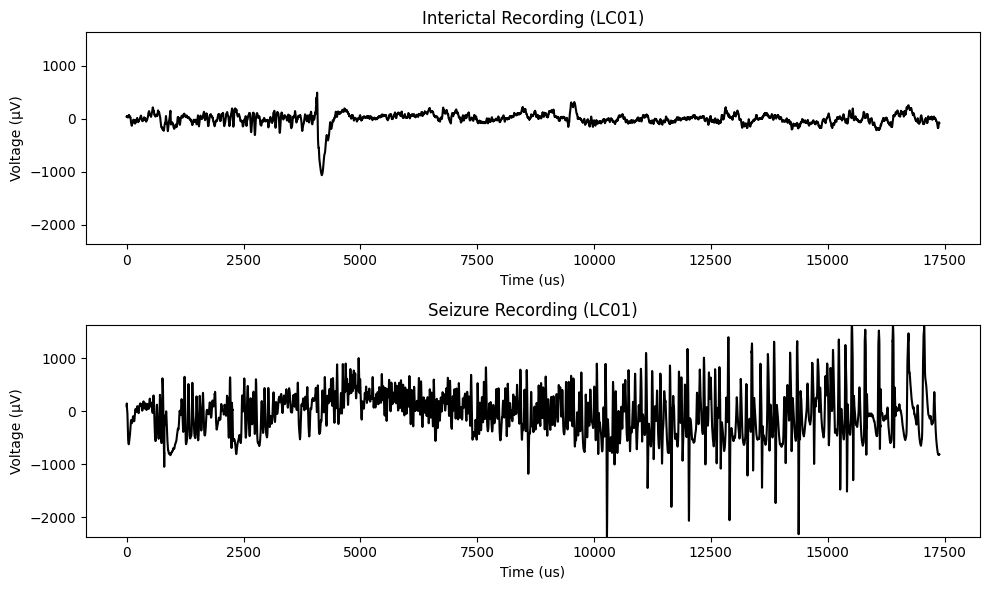

In [20]:
# My Code Here
# Determine the y-axis limits for both plots
y_min = min(LC01_Interictal_Data.min(), LC01_Seizure_Data.min())
y_max = max(LC01_Interictal_Data.max(), LC01_Seizure_Data.max())

# Plot interictal recording data
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(LC01_Interictal_Data, color='black')
plt.title('Interictal Recording (LC01)')
plt.xlabel('Time (us)')
plt.ylabel('Voltage (μV)')
plt.ylim(y_min, y_max)  # Set y-axis limits

# Plot seizure recording data
plt.subplot(2, 1, 2)
plt.plot(LC01_Seizure_Data, color='black')
plt.title('Seizure Recording (LC01)')
plt.xlabel('Time (us)')

### Two plots have the same y axes
plt.ylabel('Voltage (μV)')
plt.ylim(y_min, y_max)  # Set y-axis limits

plt.tight_layout()
plt.show()

#### 1c
In the plot of the interictal clip, you can see what we call an epileptiform spike in between 2 and 5 seconds in. Epileptiform spikes are brief discharges of synchronized activity that we frequently see in and around the seizure onset zone.  Why might it cause problems if we train our autoregressive seizure detection algorithm on a window containing the spike if spikes are small discharges of epileptic activity? (1 pts)

**My Answer Here:**

**If spikes are small discharges of epileptic activity, it's harder for us to distinguish exact spike from clusters with similar spikes, and then our test accuracy of autoregressive seizure detection algorithm on such as window would definitely be greatly reducded.**

### 2 (5 pts)

Now that we have real EEG data, we'll be using the model architecture that we developed in the previous section to build a seizure detector. Before we train and test our deep learning models, we need to prepare our training data. We're going to use the first second of the interictal clip at 60000s as our training data.

#### 2a
Downsample the training sample to 512Hz using scipy's `decimate` function, and build a hankel matrix for the first channel, `LC01`, based on 12 input samples and 1 output sample (the same as the first section). Plot the downsampled EEG clip and print the shape of your hankel matrix (2 pts).

In [21]:
# My Code Here
# Scientific Computing Imports
from scipy.signal import decimate

# print(len(LC01_Interictal_Data))
training_duration = 1
# Number of samples to extract for training
num_train_samples = int(training_duration * sample_rate)

# Extract the training data from the interictal clip
LC01_Training_Data = LC01_Interictal_Data[:num_train_samples]
print("First second of the interictal clip(Training Data)(μV):\n", LC01_Training_Data)
print("\n\nLength of Training Data:", len(LC01_Training_Data))

First second of the interictal clip(Training Data)(μV):
 [[  39.0782869 ]
 [  43.33170589]
 [  45.99009275]
 ...
 [-187.68211262]
 [-184.75788707]
 [-180.77030677]]


Length of Training Data: 1024


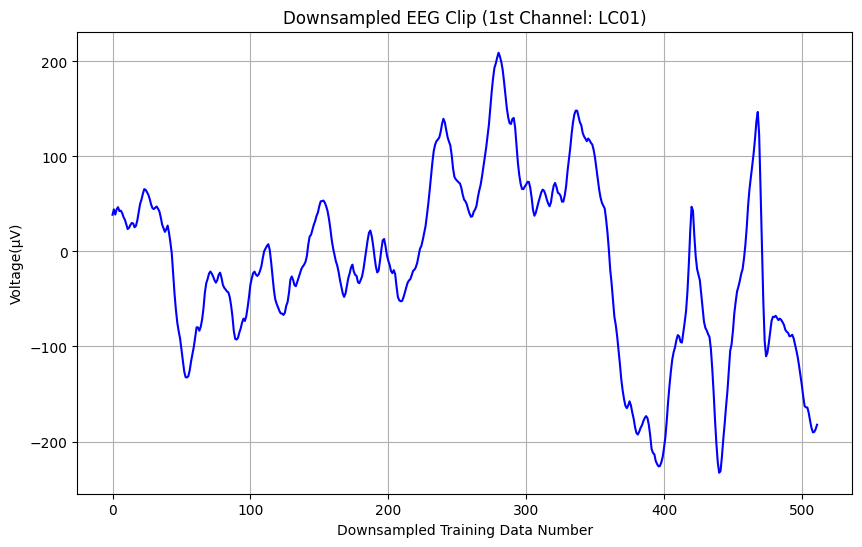



Shape of 1st Channel's Training Hankel Matrix: (500, 13)

LC01 Channel's Training Hankel Matrix(μV):
 [[  38.66803491   44.3322397    38.8752514  ...   28.63141215
    23.6182211    24.87318666]
 [  44.3322397    38.8752514    44.26939964 ...   23.6182211
    24.87318666   27.97236143]
 [  38.8752514    44.26939964   46.60698529 ...   24.87318666
    27.97236143   30.01759948]
 ...
 [-111.41544075 -120.84938262 -131.25700513 ... -185.8464631
  -190.39459071 -189.83286313]
 [-120.84938262 -131.25700513 -140.99759177 ... -190.39459071
  -189.83286313 -186.89460675]
 [-131.25700513 -140.99759177 -153.01872894 ... -189.83286313
  -186.89460675 -182.32848863]]


In [22]:
# My Code Here
### We're going to use the first second of the interictal clip at 60000s as our training data: LC01_Interictal_Data
downsample_factor = int(sample_rate / 512)
# print(downsample_factor)
LC01_Train_Downsampled = decimate(LC01_Training_Data, downsample_factor, axis = 0)

# Plot the downsampled EEG clip
plt.figure(figsize=(10, 6))
plt.plot(LC01_Train_Downsampled, color='blue')
plt.title('Downsampled EEG Clip (1st Channel: LC01)')
plt.xlabel('Downsampled Training Data Number')
plt.ylabel('Voltage(μV)')
plt.grid(True)
plt.show()

# Build a Hankel matrix for the downsampled data
num_output_samples = 1
num_InOut_samples = 13

LC01_Train_Total_Samples = len(LC01_Train_Downsampled)

LC01_Num_Sequences = LC01_Train_Total_Samples - num_InOut_samples + 1

# Train_LC01_Hankel_Matrix = hankel(LC01_Train_Downsampled[:-num_output_samples], LC01_Train_Downsampled[-num_output_samples-1:-1])
Train_LC01_Hankel_Matrix = hankel(LC01_Train_Downsampled[0:LC01_Num_Sequences], LC01_Train_Downsampled[LC01_Num_Sequences - 1 : LC01_Train_Total_Samples])

# Print the shape of the Hankel matrix
print("\n\nShape of 1st Channel's Training Hankel Matrix:", Train_LC01_Hankel_Matrix.shape)
print("\nLC01 Channel's Training Hankel Matrix(μV):\n", Train_LC01_Hankel_Matrix)

**My Answer Here:**

Shape of 1st Channel's Hankel Matrix: **(500, 13)**

#### 2b
Now let's do the machine learning part again! You can use your same code from part one to create input and target data, initialize the dataloader, and initialize the model. Then run the training loop to train a new model for the one-second interictal clip while again printing out the loss every 10 epochs. (3 pts)

Hint: The final loss should be just below 6500, much higher than when training on a perfect oscillator like before!

In [23]:
# Prepare input and target data for the LSTM
# LC01_Downsampled_Test = decimate(LC01_Seizure_Data, downsample_factor, axis = 0)
# print(LC01_Downsampled_Test)
# print(len(LC01_Downsampled_Test))
# print(Train_LC01_Hankel_Matrix)
Train_LC01_Hankel_Matrix = torch.tensor(Train_LC01_Hankel_Matrix).float()

# Extract input sequences (excluding the output)
LC01_input_data = Train_LC01_Hankel_Matrix[:, :num_input_samples].unsqueeze(-1)
# input_data = target_data.float()
# print(len(input_data))
# print(input_data)

# Extract output sequences
LC01_target_data = Train_LC01_Hankel_Matrix[:, num_input_samples:]
# target_data = target_data.float()
# target_data = target_data.squeeze(1)
# print(len(target_data))

# Print the dimensions of input_data and target_data
print("Dimensions of Input Data:", LC01_input_data.shape)
print("Dimensions of Target Data:", LC01_target_data.shape)

Dimensions of Input Data: torch.Size([500, 12, 1])
Dimensions of Target Data: torch.Size([500, 1])


In [24]:
# My Code Here
# Initialize the model
LC01_tensor_dataset = TensorDataset(LC01_input_data, LC01_target_data)
# print(tensor_dataset)
LC01_data_loader = DataLoader(LC01_tensor_dataset, batch_size = 100, shuffle  =False)
# print(data_loader)
# Create an instance of the LSTMModel
LC01_model = LSTMModel(input_size, hidden_size, output_size)
print(LC01_model,"\n\n")

# Define loss function and optimizer
# Define the learning rate for the optimizer

# Define loss function
LC01_optimizer = optim.Adam(LC01_model.parameters(), lr = optimizer_learning_rate)

# Define optimizer
LC01_criterion = nn.MSELoss()

# Print the optimizer and criterion
print("LC01 Optimizer:", LC01_optimizer)
print("LC01 Criterion:", LC01_criterion)

LSTMModel(
  (lstm): LSTM(1, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
) 


LC01 Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
LC01 Criterion: MSELoss()


In [25]:
# Training loop
num_epochs = 100
Train_Interictal_Loss = []

for epoch in range(num_epochs):

  # My Code Here!
  for _, (LC01_inputs, LC01_targets) in enumerate(LC01_data_loader):

    # print(inputs)
    # print(targets)

    ### Zero Gradients
    LC01_optimizer.zero_grad()

    ### Foward Pass
    LC01_pred_output = LC01_model(LC01_inputs)

    ### Compute Loss Function
    Train_LC01_Loss = LC01_criterion(LC01_pred_output, LC01_targets)

    ### Backward Pass
    Train_LC01_Loss.backward()

    ### Gradient Descent
    LC01_optimizer.step()

    Train_Interictal_Loss.append(Train_LC01_Loss.item())

  if epoch % 10 == 9:
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {Train_LC01_Loss.item():.4f}')

Epoch [10/100], Loss: 12079.2627
Epoch [20/100], Loss: 11316.1699
Epoch [30/100], Loss: 10563.7578
Epoch [40/100], Loss: 9852.6572
Epoch [50/100], Loss: 9206.7002
Epoch [60/100], Loss: 8540.9316
Epoch [70/100], Loss: 8012.3799
Epoch [80/100], Loss: 7467.0317
Epoch [90/100], Loss: 6918.4351
Epoch [100/100], Loss: 6473.7812


**My Answer Here:**

Epoch [10/100], Loss: 12079.2627

Epoch [20/100], Loss: 11316.1699

Epoch [30/100], Loss: 10563.7578

Epoch [40/100], Loss: 9852.6572

Epoch [50/100], Loss: 9206.7002

Epoch [60/100], Loss: 8540.9316

Epoch [70/100], Loss: 8012.3799

Epoch [80/100], Loss: 7467.0317

Epoch [90/100], Loss: 6918.4351

**Epoch [100/100], Loss: 6473.7812**

### 3 (5 pts)

#### 3a
Pull the first second of the first seizure in the csv, along with 1 second of interictal data starting at the given interictal time for the same seizure from `HUP235_phaseII` on iEEG. (1 pts)

In [26]:
# My Code Here
# seizure_data = load_full_channels(dataset1, (duration - interictal_start_time * 10**6) / 10**6, sample_rate, [LC01_Channel_Index])

# Extract seizure onset time for the first seizure
# LC01_Seizure_OnsetTime = seizure_df.loc[0, 'Onset']
# LC01_Seizure_OffsetTime = seizure_df.loc[0, 'Offset']

# Duration of the seizure (assuming duration is from onset to offset)
# LC01_Seizure_Duration = (LC01_Seizure_OffsetTime - LC01_Seizure_OnsetTime) * 10**6

# Assuming interictal recording starts at 60000 seconds = 60000 * 10^6 us
# interictal_start_time = 60000

### ictal clip
# LC01_Ictal_Data = dataset1.get_data(LC01_Seizure_OnsetTime * 10**6, training_duration * 10**6,[LC01_Channel_Index])
LC01_Ictal_Data = LC01_Seizure_Data[:num_train_samples]
# print(LC01_Ictal_Data)
# LC01_Ictal_Data = LC01_Ictal_Data[:num_train_samples]
LC01_Ictal_Downsampled = decimate(LC01_Ictal_Data, downsample_factor, axis = 0)
LC01_Ictal_TotalSamples = len(LC01_Ictal_Downsampled)
LC01_Ictal_NumSequences = LC01_Ictal_TotalSamples - num_InOut_samples + 1
Ictal_LC01_Hankel_Matrix = hankel(LC01_Ictal_Downsampled[0:LC01_Ictal_NumSequences], LC01_Ictal_Downsampled[LC01_Ictal_NumSequences - 1 : LC01_Ictal_TotalSamples])
Ictal_LC01_Hankel_Matrix = torch.tensor(Ictal_LC01_Hankel_Matrix).float()
print("Shape of 1st Channel's Clip Hankel Matrix:", Ictal_LC01_Hankel_Matrix.shape)
print("LC01 Channel's Clip Hankel Matrix(μV):\n", Ictal_LC01_Hankel_Matrix)

### interictal clip
LC01_Interictal_Time = seizure_df.loc[0, 'Interictal']
LC01_Interictal_Data2 = dataset1.get_data(LC01_Interictal_Time * 10**6, training_duration * 10**6,[LC01_Channel_Index])
# print(LC01_Interictal_Data)
LC01_Interictal_Downsampled = decimate(LC01_Interictal_Data2, downsample_factor, axis = 0)
LC01_Interictal_TotalSamples = len(LC01_Interictal_Downsampled)
LC01_Interictal_NumSequences = LC01_Interictal_TotalSamples - num_InOut_samples + 1
Interictal_LC01_Hankel_Matrix = hankel(LC01_Interictal_Downsampled[0:LC01_Interictal_NumSequences], LC01_Interictal_Downsampled[LC01_Interictal_NumSequences - 1 : LC01_Interictal_TotalSamples])
Interictal_LC01_Hankel_Matrix = torch.tensor(Interictal_LC01_Hankel_Matrix).float()
print("\n\nShape of 1st Channel's Interictal Hankel Matrix:", Interictal_LC01_Hankel_Matrix.shape)
print("LC01 Channel's Interictal Hankel Matrix(μV):\n", Interictal_LC01_Hankel_Matrix)

Shape of 1st Channel's Clip Hankel Matrix: torch.Size([500, 13])
LC01 Channel's Clip Hankel Matrix(μV):
 tensor([[  88.6792,  140.8112,  118.1031,  ..., -158.8875, -230.4868,
         -301.1121],
        [ 140.8112,  118.1031,   61.6446,  ..., -230.4868, -301.1121,
         -373.2594],
        [ 118.1031,   61.6446,   22.7167,  ..., -301.1121, -373.2594,
         -438.9315],
        ...,
        [-697.9952, -693.6652, -694.7177,  ..., -699.8763, -697.1935,
         -697.5473],
        [-693.6652, -694.7177, -696.9601,  ..., -697.1935, -697.5473,
         -697.9427],
        [-694.7177, -696.9601, -699.5231,  ..., -697.5473, -697.9427,
         -692.0206]])


Shape of 1st Channel's Interictal Hankel Matrix: torch.Size([500, 13])
LC01 Channel's Interictal Hankel Matrix(μV):
 tensor([[-73.9186, -64.7775, -78.6059,  ..., -62.0131, -24.5927, -40.2028],
        [-64.7775, -78.6059, -76.3359,  ..., -24.5927, -40.2028, -33.8990],
        [-78.6059, -76.3359, -61.9355,  ..., -40.2028, -33.8990,

#### 3b
Generate mse distributions for each of the three clips (training clip, interictal clip, ictal clip) using your predict function from section 1 (1 pt).

In [27]:
# My Code Here
### mse distributions for training clip
train_mse_values = predict_mse_values(LC01_model, Train_LC01_Hankel_Matrix)[0]
# print(train_mse_values)

### mse distributions for interictal clip
ictal_mse_values = predict_mse_values(LC01_model, Ictal_LC01_Hankel_Matrix)[0]
# print(ictal_mse_values)

### mse distributions for ictal clip
interictal_mse_values = predict_mse_values(LC01_model, Interictal_LC01_Hankel_Matrix)[0]
# print(interictal_mse_values)


#### 3c
Now, make three subplots (1 row, 3 columns) in a 18 x 6 (W x H) figure: 1. plotting the downsampled interictal clip (blue) and ictal clip (red) with a legend (maintain this ictal/interictal color sceme through all three plots). 2. plot the loss of each clip with sequence number on the x axis and loss on the y axis. 3. Plot boxplots of the distributions of log-transformed squared error for the interictal and ictal clips, as well as an orange horizontal line at the 85th percentile of the loss the model generates on the TRAINING interictal clip (the one starting at 60000s). (3 pts)

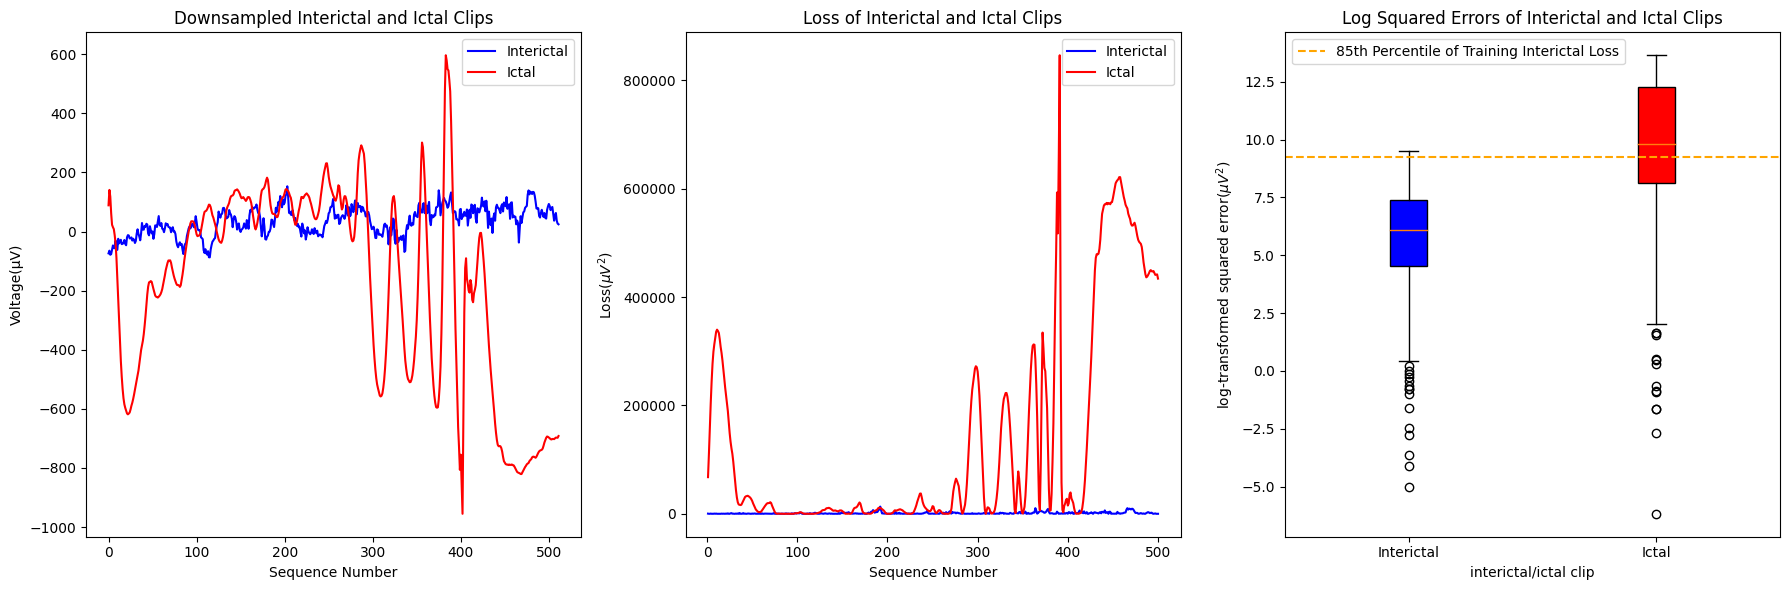

In [28]:
# My Code Here
# print(Train_LC01_Loss)
# print(Train_LC01_Loss.detach().numpy())
percentile_85_loss = np.percentile(train_mse_values, 85)
# print(np.log(percentile_85_loss))
segment_numbers2 = np.arange(1, 501)

# Prepare necessary data (replace placeholders with actual data)
# Create figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# First subplot: Plot downsampled clips
axs[0].plot(LC01_Interictal_Downsampled, color='blue', label='Interictal')
axs[0].plot(LC01_Ictal_Downsampled, color='red', label='Ictal')
axs[0].set_xlabel('Sequence Number')
axs[0].set_ylabel('Voltage(μV)')
axs[0].legend()
axs[0].set_title('Downsampled Interictal and Ictal Clips')

# Second subplot: Plot loss of each clip
axs[1].plot(segment_numbers2, interictal_mse_values, label='Interictal', color='blue')
axs[1].plot(segment_numbers2, ictal_mse_values, label='Ictal', color='red')
axs[1].set_xlabel('Sequence Number')
axs[1].set_ylabel(r'Loss($μV^2$)')
axs[1].legend()
axs[1].set_title('Loss of Interictal and Ictal Clips')

# Third subplot: Plot boxplots of squared errors
boxplot_colors = ['blue', 'red']
boxplot_labels = ['Interictal', 'Ictal']

boxplot_data = [np.log(interictal_mse_values.reshape(-1)), np.log(ictal_mse_values).reshape(-1)]

# Create boxplot
box = axs[2].boxplot(boxplot_data, labels=boxplot_labels, patch_artist = True)

# Set boxplot colors
for patch, color in zip(box['boxes'], boxplot_colors):
    patch.set_facecolor(color)

# Add horizontal line for 85th percentile
axs[2].axhline(np.log(percentile_85_loss), color='orange', linestyle='--', label='85th Percentile of Training Interictal Loss')
axs[2].set_xlabel('interictal/ictal clip')
axs[2].set_ylabel(r'log-transformed squared error($μV^2$)')
axs[2].legend()
axs[2].set_title('Log Squared Errors of Interictal and Ictal Clips')

# Show plot
plt.tight_layout()
plt.show()

You can see from the plot, that the MSE values are going to make a great feature for detecting seizures.  Now that you've done this for one seizure on one channel, we're going to scale things up a little bit...

### 4 (14 pts)
We're going to deviate from the paper here for simplicity. Instead of using their unsupervised clustering algorithm, we're going to just use the 85th percentile of interictal loss as our decision boundary and use it to threshold the **mean MSE value across a new clip** to predict ictal (above) or interictal (below). Remember to use the interictal loss from the TRAINING clip (starting at 60000s) to create your decision threshold.

#### 4a
To evaluate our model on it's ability to determine if any given one second clip comes from a seizure or is interictal, we need to write a new prediction function that converts an input clip into an ictal/interictal classifier. Try it out on the ictal clip from the previous question - it should predict Ictal! (3 pts)

In [29]:
# My Code Here
print("Threshold of Loss(μV^2):", percentile_85_loss)

def ictal_interictal_classifier(mean_mse, threshold):

  if mean_mse > threshold:
    prediction = 'ictal'
    ### Asume 'ictal' -> 1
    bool_pred = 1

  if mean_mse < threshold:
    prediction = 'interictal'
    ### Asume 'interictal' -> 0
    bool_pred = 0

  return prediction, bool_pred

### Assuming mean_mse is the mean MSE value across the Previous Ictal Clip
### and threshold is the decision threshold determined from the 85th percentile of interictal loss
ictal_mean_mse = np.mean(ictal_mse_values)
# print(ictal_mean_mse)
predicted_ictal_class = ictal_interictal_classifier(ictal_mean_mse, percentile_85_loss)
print("Predicted Ictal Clip from The Previous Question:", predicted_ictal_class)

Threshold of Loss(μV^2): 10607.225732421872
Predicted Ictal Clip from The Previous Question: ('ictal', 1)


**My Answer Here:**

**Predicted Ictal Clip from The Previous Question: ictal**

In [30]:
# My Code Here
interictal_mean_mse = np.mean(interictal_mse_values)
# print(interictal_mean_mse)
predicted_interictal_class = ictal_interictal_classifier(interictal_mean_mse, percentile_85_loss)
print("Predicted Interictal Clip from The Previous Question:", predicted_interictal_class)

Predicted Interictal Clip from The Previous Question: ('interictal', 0)


**My Answer Here:**

Predicted Ictal Clip from The Previous Question: ictal (1)

Predicted Interictal Clip from The Previous Question: interictal (0)

**Such two paris of accurately matched results shows that my design of ictal/interictal classifier can successfully detect an originally unkown clip is either ictal or interictal!**

Now that we can generate predictions on a new clip, let's formulate our machine learning problem. We're going to be trying to classify ictal vs. interictal on the `LC01` channel for `HUP235_phaseII` across all **eleven** of their seizures. To create a balanced dataset for evaluating our model we need to have equal numbers of interictal and ictal clips. What are some limitations to using equal numbers of seizure and normal data when we think about translating this algorithm to an implanted device? (2 pts).

**My Answer Here:**

There are many limitations when training a seizure detection algorithm for translation to an implanted device using an equal amount of seizure (ictal) and average (interictal) data.

**First, it might not fairly depict data distribution in real life because seizures are rare compared to regular brain activity.** This imbalance may reduce the algorithm's sensitivity to seizure detection by favoring the detection of typical occurrences. Equal representation may also conflict with the therapeutic objective of optimizing sensitivity, which is essential for reducing false negatives in seizure detection.

**Furthermore, the method would not translate well to a variety of individuals with distinct seizure patterns, and it might place computational demands on implanted devices—which frequently have constrained resources—by requiring them to do specific tasks.**

Therefore, while balancing the dataset simplifies training, it's imperative to consider the clinical context, data distribution, and device limitations to deploy seizure detection algorithms in implanted devices effectively.


#### 4b
Because the seizures are not an even number of seconds (it would be weird if they were), we're going to **round down** to the nearest integer number of seconds for each seizure (16.57s -> 16s -> 16 clips). Then, we want to pull a matched amount of interictal data with the same duration starting at the given `Interictal` time for each seizure.

Now, using all of the tools/lines of code from the previous questions, make two seperate matrices, one for interictal and one for ictal clips. The dimensions of the tensors should be num_clips x clip samples. You should include all of the 1 second clips from every seizure and every matched interictal period. Remember to downsample to 512 Hz! (4 pts)

In [31]:
print("Raw Clip #1:", LC01_Seizure_OffsetTime - LC01_Seizure_OnsetTime)
print("Round Down Clip #1:", int(LC01_Seizure_OffsetTime - LC01_Seizure_OnsetTime))

Raw Clip #1: 16.982199999998556
Round Down Clip #1: 16


In [32]:
# My Code Here
# Define the downsampling factor
# Initialize lists to store ictal and interictal clips
ictal_clips = []
interictal_clips = []

# Iterate through each seizure
for index, seizure_row in seizure_df.iterrows():
    # Extract seizure onset and offset times
    seizure_onset = seizure_row['Onset']
    seizure_offset = seizure_row['Offset']

    # Extract matched interictal start time
    interictal_start = seizure_row['Interictal']

    ### We're going to round down to the nearest integer number of seconds for each seizure
    round_down_clips = int(seizure_offset - seizure_onset)

    # Extract seizure data
    seizure_data = dataset1.get_data(seizure_onset * 10**6, round_down_clips * 10**6, [LC01_Channel_Index])
    # print(seizure_data,'\n')
    seizure_clip_data = np.split(seizure_data, round_down_clips)
    # print(seizure_clip_data)
    # for split in len(seizure_clip_data):
    # seizure_clip_data = seizure_data[:num_train_samples]
    seizure_clip_data = [array.reshape(array.shape[0], -1) for array in seizure_clip_data]
    # print(seizure_clip_data)
    # print(len(seizure_clip_data))

    # Extract matched interictal data
    interictal_data = dataset1.get_data(interictal_start * 10**6, round_down_clips * 10**6, [LC01_Channel_Index])
    # print(interictal_data)
    interictal_clip_data = np.split(interictal_data, round_down_clips)
    interictal_clip_data = [array.reshape(array.shape[0], -1) for array in interictal_clip_data]

    ### Downsample seizure and interictal data
    # seizure_data_downsampled = decimate(seizure_data, downsample_factor, axis=0)
    seizure_data_downsampled = decimate(seizure_clip_data, downsample_factor, axis=1)
    # print(seizure_data_downsampled)
    # print(len(seizure_data_downsampled))
    # seizure_data_downsampled = torch.tensor(seizure_data_downsampled).float()

    # interictal_data_downsampled = decimate(interictal_data, downsample_factor, axis=0)
    interictal_data_downsampled = decimate(interictal_clip_data, downsample_factor, axis=1)

    ### Append downsampled data to respective ictal and interictal lists
    ictal_clips.append(seizure_data_downsampled)
    # seizure_data_downsampled = np.array(seizure_data_downsampled)
    # ictal_clips = np.vstack((ictal_clips, seizure_data_downsampled)) # Different Shapes
    # ictal_clips = np.concatenate(seizure_data_downsampled, axis = 1) # Different Shapes

    interictal_clips.append(interictal_data_downsampled)

# print(ictal_clips)
# print(ictal_clips[0])
# print(ictal_clips[0].shape)
# print(ictal_clips[2].shape)
# print(interictal_clips)
# print(interictal_clips[0].shape)
# print(interictal_clips[2].shape)

# Find the maximum length among all arrays
def pad_clips(clips):
  max_length = max(arr.shape[0] for arr in clips)
  padded_clips = []
  for arr in clips:
    # Resize or pad along the first dimension
    if arr.shape[0] < max_length:
      padded_arr = np.pad(arr, ((0, max_length - arr.shape[0]), (0, 0), (0, 0)), mode='constant')
    else:
      padded_arr = arr
    padded_clips.append(padded_arr)
  return padded_clips

# Pad each array so that they have the same size along the first dimension
# padded_clips = [np.pad(arr, ((0, max_length - arr.shape[0]), (0, 0), (0, 0)), mode='constant') for arr in ictal_clips]
padded_ictal = pad_clips(ictal_clips)
total_ictal_clips = np.concatenate(padded_ictal, axis = 0)
ictal_clips_index = np.any(total_ictal_clips != 0, axis=(1, 2))
total_ictal_clips = total_ictal_clips[ictal_clips_index]
# print(total_ictal_clips)
# print(total_ictal_clips.shape)
# Convert lists to numpy arrays
# ictal_clips = torch.tensor(ictal_clips)
# print(ictal_clips)
# print(len(ictal_clips))

ictal_tensor = torch.tensor(total_ictal_clips).float()
ictal_tensor = ictal_tensor.view(527, 512)
print("Shpe of Ictal Tensor(μV):", ictal_tensor.shape)
print("Ictal Tensor:\n", ictal_tensor)

padded_interictal = pad_clips(interictal_clips)
total_interictal_clips = np.concatenate(padded_interictal, axis = 0)
interictal_clips_index = np.any(total_interictal_clips != 0, axis=(1, 2))
total_interictal_clips = total_interictal_clips[interictal_clips_index]
# print(total_interictal_clips.shape)
interictal_tensor = torch.tensor(total_interictal_clips).float()
interictal_tensor = interictal_tensor.view(527, 512)
print("\n\nShpe of Interictal Tensor:", interictal_tensor.shape)
print("Interictal Tensor(μV):\n", interictal_tensor)

# ictal_matrix = np.array(ictal_clips)
# interictal_matrix = np.array(interictal_clips)

Shpe of Ictal Tensor(μV): torch.Size([527, 512])
Ictal Tensor:
 tensor([[  88.6792,  140.8112,  118.1031,  ..., -697.5473, -697.9427,
         -692.0206],
        [-676.9438, -666.7419, -656.3646,  ...,   49.3817,   26.0938,
           11.4479],
        [   6.0450,    5.0975,    7.1751,  ..., -266.4844, -243.4174,
         -215.4709],
        ...,
        [ -47.2996,  -52.2831,  -52.6594,  ...,  265.2556,  223.6255,
          159.2314],
        [ 364.2108,  432.3869,  262.4820,  ..., -215.4157, -189.7931,
         -159.9165],
        [-194.8512, -201.7660, -186.6670,  ..., -247.3431, -242.9844,
         -265.1786]])


Shpe of Interictal Tensor: torch.Size([527, 512])
Interictal Tensor(μV):
 tensor([[-73.9186, -64.7775, -78.6059,  ...,  36.3628,  26.8283,  24.4537],
        [ 35.5402, -15.8683, -19.4690,  ..., -10.2385,  -9.5281, -12.1746],
        [-22.0251, -27.2983, -33.4137,  ...,  24.3411,  26.8291,  29.2786],
        ...,
        [126.2036, 114.7048, 121.9175,  ..., 143.3587, 144.

We need to turn our ictal and interictal clips into a dataset that we can use to evaluate the capabilities of our model. Combine them into one matrix using `np.vstack`, and create a vector with the same number of rows that contains the target labels for each clip (1 for ictal, 0 for interictal). (1 pts)

In [33]:
# Combine ictal and interictal clips into one matrix
combined_ictal_interictal = np.vstack((ictal_tensor, interictal_tensor))
print("Combined Tensor with Ictal and Interictal Clips:", combined_ictal_interictal.shape)
# print(combined_ictal_interictal)

combined_ictal_interictal = torch.tensor(combined_ictal_interictal).float()
target_labels_lst = []
for i in range(527):
  target_labels_lst.append(1)
for i in range(527, 1054):
  target_labels_lst.append(0)

target_labels_lst = np.array(target_labels_lst).reshape(1054,1)
# print(target_labels_lst.shape)
# print("Vector(Target Labels) with the same number of rows that contains the target labels for each clip:\n", target_labels_lst)
print("Shape of Vector(Target Labels) with the same number of rows that contains the target labels for each clip:", target_labels_lst.shape)

Combined Tensor with Ictal and Interictal Clips: (1054, 512)
Shape of Vector(Target Labels) with the same number of rows that contains the target labels for each clip: (1054, 1)


#### 4c
Now, generate predictions on your new testing dataset. This might take a while (~1-2 min if you do one prediction at a time without a GPU, ~20 seconds with GPU) so use tqdm to print how long the prediction will take (1 pts).

TQDM is a super useful package for running loops when you want to know the progress of your for-loop. I've included an example cell of how tqdm works

In [34]:
# TQDM EXAMPLE
import time
# you use tqdm by passing whatever you're going to be iterating over into the
# tqdm function and it will create a progress bar!

for i in tqdm(range(1000)):
  time.sleep(.01)

100%|██████████| 1000/1000 [00:10<00:00, 96.73it/s]


In [35]:
# My Code Here
# pred_mse_values = predict_mse_values(LC01_model, combined_ictal_interictal)[0]
# print(pred_mse_values)
# print(len(pred_mse_values))

total_combined = 512
combined_sequences = total_combined - num_input_samples

pred_labels_lst = []
for i in tqdm(range(len(combined_ictal_interictal))):
  time.sleep(.01)
  tmp_hankle = hankel(combined_ictal_interictal[i][0:combined_sequences], combined_ictal_interictal[i][combined_sequences - 1 : total_combined])
  tmp_hankle = torch.tensor(tmp_hankle).float()
  pred_mse_values = predict_mse_values(LC01_model, tmp_hankle)
  pred_mean_mse = np.mean(pred_mse_values)
  _, pred_label = ictal_interictal_classifier(pred_mean_mse, percentile_85_loss)
  pred_labels_lst.append(pred_label)
pred_labels_lst = np.array(pred_labels_lst).reshape(1054,1)
# pred_labels_lst = torch.tensor(pred_labels_lst).float()
# print("Vector(Predicted Labels) with the same number of rows that contains the target labels for each clip:\n", pred_labels_lst)

100%|██████████| 1054/1054 [01:07<00:00, 15.68it/s]


Print out the Accuracy, Precision, and Recall of our classifier as well as plotting the confusion matrix (2 pts). We've already imported `precision_score` and `recall_score` from sklearn.metrics. You'll have to write your own accuracy score function. You can use the `ConfusionMatrixDisplay` and `confusion_matrix` functions we've imported from `sklearn.metrics` to generate the confusion matrix.

Your accuracy should be around 93%, Precision should be around 87%, and Recall should be close to 100%.

Accuracy of Our Classifier: 0.9250474383301708
Precision of Our Classifier: 0.872093023255814
Recall of Our Classifier: 0.9962049335863378
Confusion Matrix:
 [[450  77]
 [  2 525]]


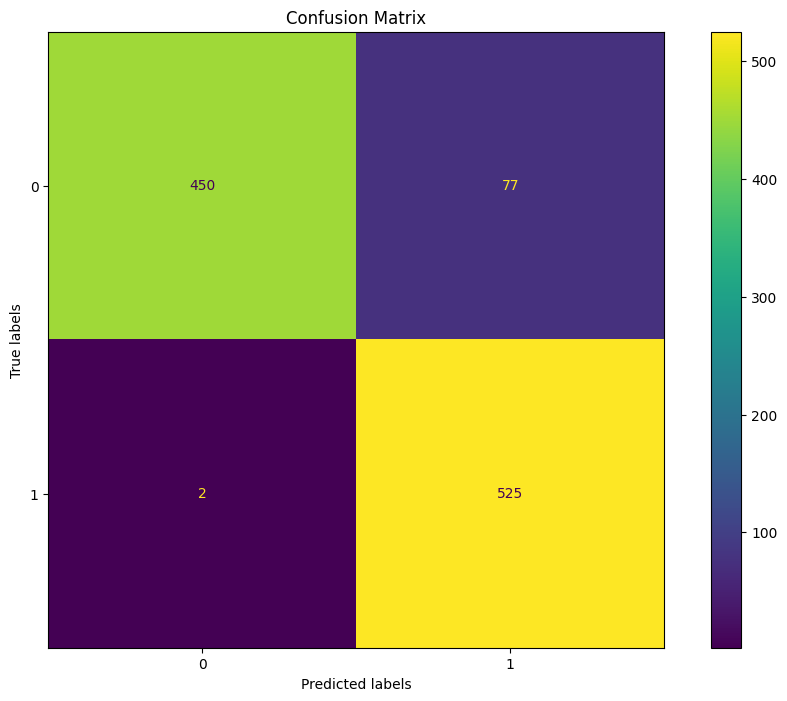

In [36]:
# My Code Here
Accuracy_Count = 0

for j in range(len(target_labels_lst)):
  if target_labels_lst[j] == pred_labels_lst[j]:
    Accuracy_Count = Accuracy_Count + 1
  if target_labels_lst[j] != pred_labels_lst[j]:
    Accuracy_Count = Accuracy_Count
# print(Accurate_Count)

### Length is as same as Number of Epochs in True and Pred: 85
Accuracy = Accuracy_Count / len(target_labels_lst)
print("Accuracy of Our Classifier:", Accuracy)

Precision = precision_score(target_labels_lst, pred_labels_lst)
print("Precision of Our Classifier:", Precision)

Recall = recall_score(target_labels_lst, pred_labels_lst)
print("Recall of Our Classifier:", Recall)

# Calculate confusion matrix
cm = ConfusionMatrixDisplay(confusion_matrix(target_labels_lst, pred_labels_lst))
print("Confusion Matrix:\n", confusion_matrix(target_labels_lst, pred_labels_lst))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(12,8))
# sns.heatmap(cm, annot = True, cmap='Blues', fmt='g', cbar=False)
cm.plot(ax = ax)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

**My Answer Here:**

**Accuracy of Our Classifier: 0.9250474383301708**

**Precision of Our Classifier: 0.872093023255814**

**Recall of Our Classifier: 0.9962049335863378**

**Confusion Matrix: [[450  77][  2 525]]**

You can see from the confusion matrix and the metrics that we calculate that our classifier is very good at detecting seizures (high sensitivity), but can struggle to tell some interictal clips from seizures. Why might this be the case? (1 pts)

**My Answer Here:**

85th percentile of the Loss the model generates on the TRAINING interictal clip (the one starting at 60000s) provides our chosen threshold of Loss (μV^2): 10607.225732421872.

**Because such a chosen threshold may go beyond most interictal clips from seizures but still on the bottom of most ictal clips, our classifier would accumulate noticeably greater ictal clips than interictal clips.**

As we know, interictal clips represent represent time of patient `HUP235` without seizures("Noraml" EEG), while ictal clips represent time of patient `HUP235` with seizures(Seizure Occurences), classifier is good at distinguishing ictal clips from interictal clips to detect occurrences of seizures, instead of accurately pre-alarming the potential appearance of seizures.

### 5 (7 pts)
Now comes the fun part! Throughout this homework you've learned how to format data for autoregression, build deep learning models, and train and test an LSTM for seizure detection. How you approach this last part of the homework is up to you, but your goal is to try a new method that iterates on the framework we've provided and evaluate it using the testing dataset that we built in 4b.

The Goal: Maximize accuracy and precision while minimizing training data and computational complexity.

The Rules:
* You cannot use any of the data (ictal or interictal clips) that we use to test the model in the previous section to train your model
* You cannot use ANY ictal data to train the model
* The model must be trained in an unsupervised manner
* The rest is up to you!

Write a paragraph (~3 sentences) describing your proposed method (3 pts). Then, implement your algorithm and print out the accuracy, precision, and recall of your final model. (4 pts + 1 pt Extra Credit for every improved percentage point).


**Background: **

**The most widely used Deep Learning Networks (DLNs) include attention-based algorithms that pick significant portions of the data, autoencoders that provide handy representations of the data, and LSTMs that can analyze time-series data.**

**Reference:**

[1] Bhattacharya et al., 2023.

**Describe My Proposed Method:**

**[1] I try to adjust a optimal threshold to classify ictal and interictal clips(better than 85th percentile) = maximum value of Train Interictal Loss to increase accuracy and precision.**

**[2] But adjusting a optimal threshold merely increases accuracy and precision, in order to minimizing training data and still guarantee same great accuracy, I elaborate prepocessing data as mentioned in given paper via Scaler in Pytorch. As the training data is roughly minimized, computational complexity of my model would also be modified.**

**[3] To furtherly maximize accuracy and precision, minimize training data and computational complexity, I try to design another Simple GRU Model(this model theoretically provides greater accuracy than LSTM Model, but I fail to improve accuracy with such as method); I also try PCA Algorithm to reduce dimension; and I come up ideas to choose other types of Loss Functions(eg.LOG-COSH LOSS) rather than MSE. But most of them work properly. I apologize that I have no idea to contribute to a more accurate training model.**



In [37]:
# My Code Here
### Update Environment Setup
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras # Keras is included with TF
from keras import layers, models, optimizers
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, Reshape, Conv1DTranspose
from keras.models import Model, Sequential
from keras.optimizers import Adam
# import optuna
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


**Adjust Threshold of Train Loss:**

Updated Accuracy of Our Classifier: 0.9421252371916509
Updated Precision of Our Classifier: 0.903114186851211
Updated Recall of Our Classifier: 0.9905123339658444
Updated Confusion Matrix:
 [[471  56]
 [  5 522]]


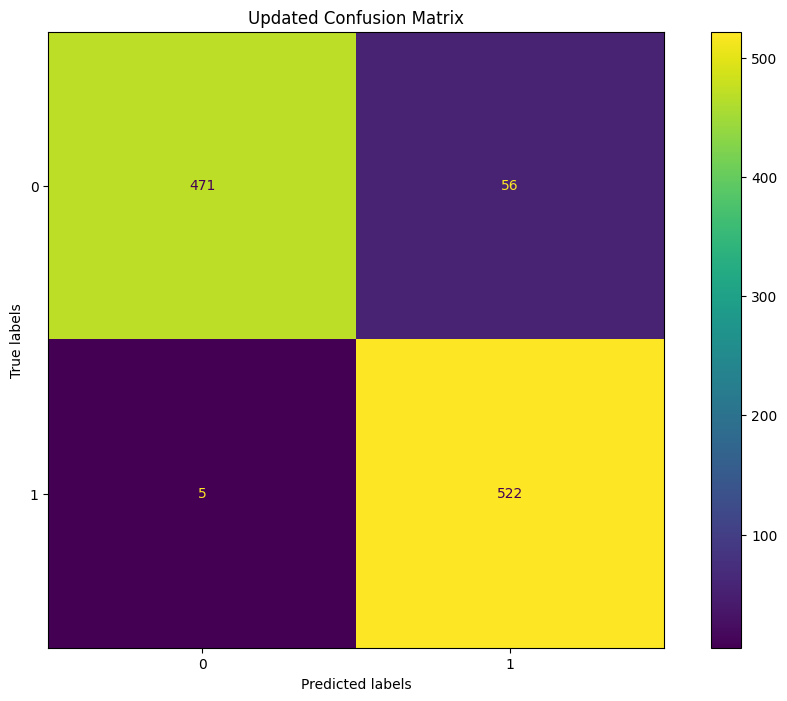

In [38]:
# My Code Here
update_threshold = np.max(Train_Interictal_Loss)
total_combined = 512
combined_sequences = total_combined - num_input_samples

pred_mse_lst2 = []
pred_labels_lst2 = []

for i in range(len(combined_ictal_interictal)):
  tmp_hankle2 = hankel(combined_ictal_interictal[i][0:combined_sequences], combined_ictal_interictal[i][combined_sequences - 1 : total_combined])
  tmp_hankle2 = torch.tensor(tmp_hankle2).float()
  pred_mse_values2 = predict_mse_values(LC01_model, tmp_hankle2)
  pred_mean_mse2 = np.mean(pred_mse_values2)
  pred_mse_lst2.append(pred_mean_mse2)
  _, pred_label2 = ictal_interictal_classifier(pred_mean_mse2, update_threshold)
  pred_labels_lst2.append(pred_label2)
pred_labels_lst2 = np.array(pred_labels_lst2).reshape(1054,1)

Accuracy_Count2 = 0

for j in range(len(target_labels_lst)):
  if target_labels_lst[j] == pred_labels_lst2[j]:
    Accuracy_Count2 = Accuracy_Count2 + 1
  if target_labels_lst[j] != pred_labels_lst2[j]:
    Accuracy_Count2 = Accuracy_Count2
# print(Accurate_Count2)

### Length is as same as Number of Epochs in True and Pred: 85
Accuracy2 = Accuracy_Count2 / len(target_labels_lst)
print("Updated Accuracy of Our Classifier:", Accuracy2)

Precision2 = precision_score(target_labels_lst, pred_labels_lst2)
print("Updated Precision of Our Classifier:", Precision2)

Recall2 = recall_score(target_labels_lst, pred_labels_lst2)
print("Updated Recall of Our Classifier:", Recall2)

# Calculate confusion matrix
cm2 = ConfusionMatrixDisplay(confusion_matrix(target_labels_lst, pred_labels_lst2))
print("Updated Confusion Matrix:\n", confusion_matrix(target_labels_lst, pred_labels_lst2))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(12,8))
# sns.heatmap(cm2, annot = True, cmap='Blues', fmt='g', cbar=False)
cm2.plot(ax = ax)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Updated Confusion Matrix')
plt.show()

**My Answer Here:**

**Accuracy of Our Classifier: 0.9421252371916509**

**Precision of Our Classifier: 0.903114186851211**

**Recall of Our Classifier: 0.9905123339658444**

**Confusion Matrix: [[471  56][  5 522]]**

**Preprocessing Train Data with Scaler(Minimize Training Data and Simplify Computational Complexity)**

In [49]:
# My Code Here
set_seed(5210)
# Preprocessing and Data Preparation
scaler = MinMaxScaler((-10, 10))
X_interictal_scaled = scaler.fit_transform(LC01_Train_Downsampled.reshape(-1,1))
Train_Scaled_Matrix = hankel(X_interictal_scaled[0:LC01_Num_Sequences], X_interictal_scaled[LC01_Num_Sequences - 1 : LC01_Train_Total_Samples])
Train_Scaled_Matrix = torch.tensor(Train_Scaled_Matrix).float()
# print(Train_Scaled_Matrix)

# combined_scaled = scaler.transform(combined_ictal_interictal)
# print(combined_scaled)

LC01_input_data2 = Train_Scaled_Matrix[:, :num_input_samples].unsqueeze(-1)
# input_data = target_data.float()
# print(len(input_data))
# print(input_data)

# Extract output sequences
LC01_target_data2 = Train_Scaled_Matrix[:, num_input_samples:]
# target_data = target_data.float()
# target_data = target_data.squeeze(1)
# print(len(target_data))

# Print the dimensions of input_data and target_data
print("Dimensions of Input Data:", LC01_input_data2.shape)
# print("Minimize Training Data:\n", LC01_input_data2)
print("\n\nDimensions of Target Data:", LC01_target_data2.shape)
# print("Minimize Training Data:", LC01_target_data2)

# Initialize the model
LC01_tensor_dataset2 = TensorDataset(LC01_input_data2, LC01_target_data2)
# print(LC01_tensor_dataset2)
LC01_data_loader2 = DataLoader(LC01_tensor_dataset2, batch_size = 100, shuffle = False)
# print(LC01_data_loader2)

# Create an instance of the LSTMModel
hidden_size2 = 120
LC01_model2 = LSTMModel(input_size, hidden_size2, output_size)
print(LC01_model2,"\n\n")

# Define loss function and optimizer
# Define the learning rate for the optimizer

# Define loss function
optimizer_learning_rate2 = 0.0005
LC01_optimizer2 = optim.Adam(LC01_model2.parameters(), lr = optimizer_learning_rate2)
LC01_criterion2 = nn.MSELoss()

# Print the optimizer and criterion
print("LC01 Optimizer:", LC01_optimizer2)
print("LC01 Criterion:", LC01_criterion2)

# Training loop
Train_Interictal_Loss2 = []

num_epochs2 = 100
for epoch in range(num_epochs2):

  # My Code Here!
  for _, (LC01_inputs2, LC01_targets2) in enumerate(LC01_data_loader2):

    # print(inputs)
    # print(targets)

    ### Zero Gradients
    LC01_optimizer2.zero_grad()

    ### Foward Pass
    LC01_pred_output2 = LC01_model2(LC01_inputs2)

    ### Compute Loss Function
    Train_LC01_Loss2 = LC01_criterion2(LC01_pred_output2, LC01_targets2)

    ### Backward Pass
    Train_LC01_Loss2.backward()

    ### Gradient Descent
    LC01_optimizer2.step()

    Train_Interictal_Loss2.append(Train_LC01_Loss2.item())

  if epoch % 10 == 9:
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {Train_LC01_Loss2.item():.4f}')

pred_scaled_mse = predict_mse_values(LC01_model2, Train_Scaled_Matrix)[0]
# print(pred_scaled_mse)

interictal_mean_mse2 = np.mean(pred_scaled_mse)

percentile_85_scaled = np.percentile(interictal_mean_mse2, 85)
print(percentile_85_scaled)

Dimensions of Input Data: torch.Size([500, 12, 1])


Dimensions of Target Data: torch.Size([500, 1])
LSTMModel(
  (lstm): LSTM(1, 120, batch_first=True)
  (fc): Linear(in_features=120, out_features=1, bias=True)
) 


LC01 Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 0
)
LC01 Criterion: MSELoss()
Epoch [10/100], Loss: 11.5358
Epoch [20/100], Loss: 6.0799
Epoch [30/100], Loss: 3.9878
Epoch [40/100], Loss: 2.6538
Epoch [50/100], Loss: 1.9788
Epoch [60/100], Loss: 1.4422
Epoch [70/100], Loss: 1.0100
Epoch [80/100], Loss: 0.7641
Epoch [90/100], Loss: 0.6502
Epoch [100/100], Loss: 0.5689
0.2366228699684143


Updated Accuracy of Our Classifier: 0.9459203036053131
Updated Precision of Our Classifier: 0.9257246376811594
Updated Recall of Our Classifier: 0.969639468690702
Updated Confusion Matrix:
 [[486  41]
 [ 16 511]]


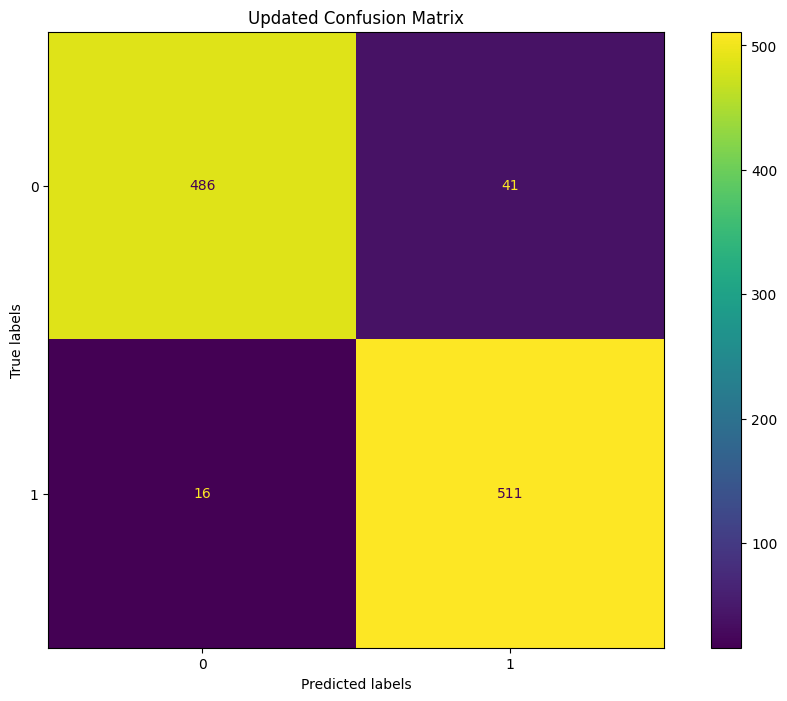

In [47]:
# My Code Here
update_threshold2 = np.max(pred_scaled_mse) * 1.5
total_combined = 512
combined_sequences = total_combined - num_input_samples

pred_mse_lst3 = []
pred_labels_lst3 = []

combined_ictal_interictal2 = combined_ictal_interictal.clone()

for i in range(len(combined_ictal_interictal2)):
  scaled_combine = scaler.transform(combined_ictal_interictal2[i].reshape(-1, 1))
  tmp_hankle3 = hankel(scaled_combine[0:combined_sequences], scaled_combine[combined_sequences - 1 : total_combined])
  tmp_hankle3 = torch.tensor(tmp_hankle3).float()
  pred_mse_values3 = predict_mse_values(LC01_model2, tmp_hankle3)
  pred_mean_mse3 = np.mean(pred_mse_values3)
  pred_mse_lst3.append(pred_mean_mse3)
  _, pred_label3 = ictal_interictal_classifier(pred_mean_mse3, update_threshold2)
  pred_labels_lst3.append(pred_label3)
pred_labels_lst3 = np.array(pred_labels_lst3).reshape(1054,1)

Accuracy_Count3 = 0

for j in range(len(target_labels_lst)):
  if target_labels_lst[j] == pred_labels_lst3[j]:
    Accuracy_Count3 = Accuracy_Count3 + 1
  if target_labels_lst[j] != pred_labels_lst3[j]:
    Accuracy_Count3 = Accuracy_Count3
# print(Accurate_Count3)

### Length is as same as Number of Epochs in True and Pred: 85
Accuracy3 = Accuracy_Count3 / len(target_labels_lst)
print("Updated Accuracy of Our Classifier:", Accuracy3)

Precision3 = precision_score(target_labels_lst, pred_labels_lst3)
print("Updated Precision of Our Classifier:", Precision3)

Recall3 = recall_score(target_labels_lst, pred_labels_lst3)
print("Updated Recall of Our Classifier:", Recall3)

# Calculate confusion matrix
cm3 = ConfusionMatrixDisplay(confusion_matrix(target_labels_lst, pred_labels_lst3))
print("Updated Confusion Matrix:\n", confusion_matrix(target_labels_lst, pred_labels_lst3))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(12,8))
# sns.heatmap(cm3, annot = True, cmap='Blues', fmt='g', cbar=False)
cm3.plot(ax = ax)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Updated Confusion Matrix')
plt.show()

**My Answer Here:**

**Updated Accuracy of Our Classifier: 0.9459203036053131**

**Updated Precision of Our Classifier: 0.9257246376811594**

**Updated Recall of Our Classifier: 0.969639468690702**

**Updated Confusion Matrix: [[486  41][ 16 511]]**

**Try Simple GRU Model, but fail to increase accuracy, and fail to improve performance:**

In [50]:
set_seed(5210)
class SimpleGRUModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(SimpleGRUModel, self).__init__()
    self.hidden_size = hidden_size

    # Define GRU layer
    self.gru = nn.GRU(input_size, hidden_size, batch_first=True)

    # Define output layer
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    # Initialize hidden state
    h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

    # Forward pass through GRU layer
    out, _ = self.gru(x, h0)

    # Decode the hidden state of the last time step
    out = self.fc(out[:, -1, :])
    return out

'''def init_hidden(self, batch_size):
    # Initialize hidden state with zeros
    return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)'''

num_layers = 1

# Create model instance
GRU_Model = SimpleGRUModel(input_size, hidden_size, output_size)

# Initialize the model
GRU_tensor_dataset = TensorDataset(LC01_input_data2, LC01_target_data2)
# print(LC01_tensor_dataset2)
GRU_data_loader = DataLoader(GRU_tensor_dataset, batch_size = 100, shuffle = False)
# print(LC01_data_loader2)

# sequence_length = 5
# Generate random input tensor
# input_tensor = torch.randn(batch_size = 100, sequence_length, input_size)

# Initialize hidden state
# hidden = GRU_Model.init_hidden(batch_size = 100)
# batch_size = 100
# hidden = torch.zeros(1, batch_size, hidden_size)

# Define loss function
GRU_optimizer = optim.Adam(GRU_Model.parameters(), lr = optimizer_learning_rate2)
GRU_criterion = nn.MSELoss()

num_epochs3 = 100
Train_Interictal_Loss3 = []

for epoch in range(num_epochs3):

  # My Code Here!
  for _, (LC01_inputs3, LC01_targets3) in enumerate(GRU_data_loader):

    # print(inputs)
    # print(targets)

    ### Zero Gradients
    GRU_optimizer.zero_grad()

    ### Foward Pass
    LC01_pred_output3 = GRU_Model(LC01_inputs3)

    ### Compute Loss Function
    Train_LC01_Loss3 = GRU_criterion(LC01_pred_output3, LC01_targets3)

    ### Backward Pass
    Train_LC01_Loss3.backward()

    ### Gradient Descent
    GRU_optimizer.step()

    Train_Interictal_Loss3.append(Train_LC01_Loss3.item())

  if epoch % 10 == 9:
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {Train_LC01_Loss3.item():.4f}')

gru_pred_scaled = predict_mse_values(GRU_Model, Train_Scaled_Matrix)[0]
# print(pred_scaled_mse)

interictal_mean_mse3 = np.mean(gru_pred_scaled)

gru_percentile_85 = np.percentile(interictal_mean_mse3, 85)
print(gru_percentile_85)

Epoch [10/100], Loss: 8.2342
Epoch [20/100], Loss: 4.4497
Epoch [30/100], Loss: 2.9302
Epoch [40/100], Loss: 2.1947
Epoch [50/100], Loss: 1.7998
Epoch [60/100], Loss: 1.4904
Epoch [70/100], Loss: 1.1962
Epoch [80/100], Loss: 0.9691
Epoch [90/100], Loss: 0.8311
Epoch [100/100], Loss: 0.7596
0.3027644157409668


Updated Accuracy of Our Classifier: 0.7998102466793169
Updated Precision of Our Classifier: 0.7146739130434783
Updated Recall of Our Classifier: 0.9981024667931688
Updated Confusion Matrix:
 [[317 210]
 [  1 526]]


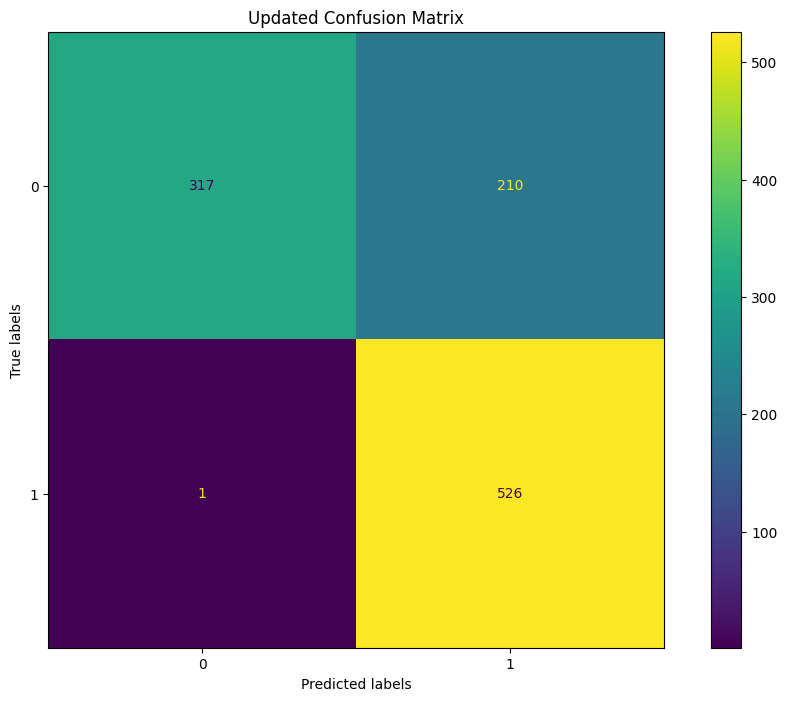

In [51]:
# My Code Here
update_threshold3 = np.max(interictal_mean_mse3) * 1.5
total_combined = 512
combined_sequences = total_combined - num_input_samples

pred_mse_lst4 = []
pred_labels_lst4 = []

combined_ictal_interictal3 = combined_ictal_interictal.clone()

for i in range(len(combined_ictal_interictal3)):
  gru_combine = scaler.transform(combined_ictal_interictal3[i].reshape(-1, 1))
  tmp_hankle4 = hankel(gru_combine[0:combined_sequences], gru_combine[combined_sequences - 1 : total_combined])
  tmp_hankle4 = torch.tensor(tmp_hankle4).float()
  pred_mse_values4 = predict_mse_values(GRU_Model, tmp_hankle4)
  pred_mean_mse4 = np.mean(pred_mse_values4)
  pred_mse_lst4.append(pred_mean_mse4)
  _, pred_label4 = ictal_interictal_classifier(pred_mean_mse4, update_threshold3)
  pred_labels_lst4.append(pred_label4)
pred_labels_lst4 = np.array(pred_labels_lst4).reshape(1054,1)

Accuracy_Count4 = 0

for j in range(len(target_labels_lst)):
  if target_labels_lst[j] == pred_labels_lst4[j]:
    Accuracy_Count4 = Accuracy_Count4 + 1
  if target_labels_lst[j] != pred_labels_lst4[j]:
    Accuracy_Count4 = Accuracy_Count4
# print(Accurate_Count4)

### Length is as same as Number of Epochs in True and Pred: 85
Accuracy4 = Accuracy_Count4 / len(target_labels_lst)
print("Updated Accuracy of Our Classifier:", Accuracy4)

Precision4 = precision_score(target_labels_lst, pred_labels_lst4)
print("Updated Precision of Our Classifier:", Precision4)

Recall4 = recall_score(target_labels_lst, pred_labels_lst4)
print("Updated Recall of Our Classifier:", Recall4)

# Calculate confusion matrix
cm4 = ConfusionMatrixDisplay(confusion_matrix(target_labels_lst, pred_labels_lst4))
print("Updated Confusion Matrix:\n", confusion_matrix(target_labels_lst, pred_labels_lst4))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(12,8))
# sns.heatmap(cm, annot = True, cmap='Blues', fmt='g', cbar=False)
cm4.plot(ax = ax)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Updated Confusion Matrix')
plt.show()

**Try PCA, TSNE, K-Means, but fail to elaborate:**

In [52]:
pca_wave = PCA(n_components=13)
PC_Converted = pca_wave.fit_transform(Train_LC01_Hankel_Matrix)
# print(PC_Converted)
# print(PC_Converted[:, 0])
# print(len(PC_Converted[:, 0]))
# print(PC_Converted[:, 1])
# print(len(PC_Converted[:, 1]))
PC_Converted = torch.tensor(PC_Converted).float()
pred_pc_mse = predict_mse_values(LC01_model, PC_Converted)
# print(pred_pc_mse)
percentile_85_PcLoss = np.percentile(pred_pc_mse, 85)
print(percentile_85_PcLoss)
'''# Initialize t-SNE object
tsne = TSNE(n_components=1, perplexity = 30, method = 'barnes_hut')
print(tsne)
# Fit and convert the TSNE Data
TSNE_Converted = tsne.fit_transform(Train_LC01_Hankel_Matrix)
print(TSNE_Converted)
print(TSNE_Converted.shape)'''


'''plt.figure(figsize = (12,8))
plt.title('Scatterplot of All Spike Waveforms in Principal Component (PC) Space')
plt.xlabel('Top Principle Component #1')
plt.ylabel('Top Principle Component #2')
plt.scatter(PC_Converted[:,0], PC_Converted[:,1])
plt.show()

PC_Cluster = KMeans(n_clusters=2,random_state=0, n_init='auto').fit(PC_Converted).predict(PC_Converted)
print(np.where(PC_Cluster == 0))
# pred_mse_values = predict_mse_values(LC01_model, PC_Converted[:,0])[0]
# print(pred_mse_values)'''

184.83522872924806


"plt.figure(figsize = (12,8))\nplt.title('Scatterplot of All Spike Waveforms in Principal Component (PC) Space')\nplt.xlabel('Top Principle Component #1')\nplt.ylabel('Top Principle Component #2')\nplt.scatter(PC_Converted[:,0], PC_Converted[:,1])\nplt.show()\n\nPC_Cluster = KMeans(n_clusters=2,random_state=0, n_init='auto').fit(PC_Converted).predict(PC_Converted)\nprint(np.where(PC_Cluster == 0))\n# pred_mse_values = predict_mse_values(LC01_model, PC_Converted[:,0])[0]\n# print(pred_mse_values)"

**Try other types of training models, but fail to elaborate:**

In [53]:
# Define the Generator network
def build_generator(latent_dim, output_shape):
    model = Sequential()
    model.add(Dense(128, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(output_shape), activation='tanh'))
    model.add(Reshape(output_shape))
    return model

# Define the Discriminator network
def build_discriminator(input_shape):
    model = Sequential()
    model.add(Conv1DTranspose(64, 3, strides=2, padding='same', input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv1DTranspose(128, 3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv1DTranspose(256, 3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Define the GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_model = Sequential()
    gan_model.add(generator)
    gan_model.add(discriminator)
    gan_model.compile(loss = 'binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    return gan_model

**Unsuccessful Attempt with LOG-COSH LOSS: Divergent to Infinity**

In [54]:
### LOG-COSH LOSS: ∑log{cosh[y(true) − y(pred)]}
def predict_log_cosh_loss(model, clip):

  log_cosh_loss_lst = []

  tmp_input_data = clip[:, :num_input_samples].unsqueeze(-1)
  tmp_target_data = clip[:, num_input_samples:]
  pred_clip_output = model(tmp_input_data)

  log_cosh_loss_tensor = torch.log(torch.cosh(tmp_target_data - pred_clip_output))
  log_cosh_loss = log_cosh_loss_tensor.mean().detach().numpy()

  log_cosh_loss_lst.append(log_cosh_loss)


  return log_cosh_loss_lst

In [55]:
### LOG-COSH LOSS for training clip
train_LogCosh_Loss = predict_log_cosh_loss(LC01_model, Train_LC01_Hankel_Matrix)[0]
print(train_LogCosh_Loss)

inf
